In [1]:
import plotly.graph_objects as go
import networkx as nx
import numpy as np
import matplotlib.pylab as plt

from utils import (get_edges, 
                   get_nodes, 
                   get_degree, 
                   build_all_to_all, 
                   build_graph_viz, 
                   build_node_trace, 
                   build_edge_trace)

# Cooperative and Competitive Homogeneous Agents

In [2]:
# G = build_all_to_all(10)

In [3]:
# adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
# print(adjacency_matrix.todense())

In [4]:
# resistance term: d_{ij} 
# In the general model, a larger dij implies a greater resistance of agent i to 
# forming a non-neutral opinion about option j

# social term: 
# the  product  of  an attention parameter ui ≥ 0 
# and a saturating function of weighted sums of agent opinions that are available 
# to agent i and influence its opinion  of  option j
# The  social  term  can  also  be  interpreted as an activation term

# The magnitude of Ajl_ik determines the  strength  of  influence  of  agent k’s  
# opinion  about  option l on  agent i’s  opinion  about  option j,  and  the
# sign  of Ajl_ik determines whether this interaction is excitatory (Ajlik>0) 
# or inhibitory (Ajlik<0).

# The input bij ∈ R represents  an  input  signal  from  the environment  
# or  a  bias  or  predisposition  that  directly  affects agent i’s  opinion  of  option j

In [5]:
# eq 5a (z is the relative opinion)
# z_ij_dot = F_ij(Z) - 1/N_o \sum_l F_il(Z)
# F_ij(Z) = -d_ij z_ij + u_i ( S_1(\sum_k Ajj_ik z_kj) + \sum_(l neq j) S_2(\sum_k Ajl_ik z_kl)) + b_ij

In [6]:
def compute_zdot(D, u, Z, social_term, B):
    '''
    computes equation of motion of relative opinions
    
    Zij_dot = F_ij(Z) - (1/No) * \sum_(l = 1)^No F_il(Z)
    
    Arguments:
    ---------
    D: matrix 
        size - (number of agents x number of options)
        resistance term. In the general model, a larger dij implies a greater resistance of agent i to 
        forming a non-neutral opinion about option j.
    
    u: vector
        len(U) = number of agents
        attention parameter.
        
    Z: matrix
        size - (number of agents x number of options)
        
    A: tuple
        (Inter-agent, same-option coupling: Ajj_ik, i neq k (Size: No x Na x Na)
         Inter-agent, inter-option coupling: Ajl_ik, i neq k,j neq l (Size: (No-1) x No x Na x Na) )
         
    B: matrix
        size - (number of agents x number of options)
        represents an input signal from the environment or a bias or predisposition that  
        directly affects agent i’s opinion of option j
        
    Returns:
    -------
    Z_dot: matrix
        size - ()
        Zij_dot = F_ij(Z) - (1/No) * \sum_(l = 1)^No F_il(Z)
    '''
    
    num_options = D.shape[-1]
    
    F = compute_drift(D, u, Z, social_term, B)
    
    average_option_drift = 1/num_options * np.einsum('il->i', F)

    return F - average_option_drift[:, np.newaxis]

In [7]:
def compute_drift(D, u, Z, social_term, B):
    '''
    computes drift using S_1 = S_2 = tanh
    
    F_ij(Z) = -d_ij z_ij + u_i ( S_1(\sum_k Ajj_ik z_kj) + \sum_(l neq j) S_2(\sum_k Ajl_ik z_kl)) + b_ij
    
    
    Arguments:
    ---------
    D: matrix 
        size - (number of agents x number of options)
        resistance term. In the general model, a larger dij implies a greater resistance of agent i to 
        forming a non-neutral opinion about option j.
    
    u: vector
        len(U) = number of agents
        attention parameter.
        
    Z: matrix
        size - (number of agents x number of options)
        
    A: tuple
        (
    B: matrix
        size - (number of agents x number of options)
        represents an input signal from the environment or a bias or predisposition that  
        directly affects agent i’s opinion of option j
    '''
    # Inter-agent matrices include intra-agent coupling to match summations in paper
    # inter_agent_same_option = A[0] # 2D matrix
    # inter_agent_inter_option = A[1] # 3D matrix
    
    # social_term = compute_social_term(inter_agent_same_option, inter_agent_inter_option, Z, u)
    
    # F_ij(Z) = -d_ij z_ij + u_i ( S_1(\sum_k Ajj_ik z_kj) + \sum_(l neq j) S_2(\sum_k Ajl_ik z_kl)) + b_ij
    return -D * Z + social_term + B

In [8]:
def compute_social_term(inter_agent_same_option, inter_agent_inter_option, Z, u):
    '''
    computes the social term which is
    the  product  of  an attention parameter ui ≥ 0 
    and a saturating function of weighted sums of agent opinions that are available 
    to agent i and influence its opinion  of  option j
    
    Arguments:
    ----------
    inter_agent_same_option: matrix
        Size: number of options x number of agents x number of agents
        Inter-agent, same-option coupling: Ajj_ik, i neq k 
        
    inter_agent_inter_option: matrix
        Size: (number of options - 1) x number of options x number of agents x number of agents)
        Inter-agent, inter-option coupling: Ajl_ik, i neq k,j neq l 
    
    Z: matrix
        Size: (number of agents x number of options)
        
    u: vector:
        Size: (number of agents x 1)
        
    Returns:
    -------
    social_term: matrix
        Size: number of agents x number of options
    '''
    # print('inter_agent_same_option shape: {}'.format(inter_agent_same_option.shape))
    # print('inter_agent_inter_option shape: {}'.format(inter_agent_inter_option.shape))

    weighted_inter_agent_same_option = np.einsum('jik,kj->ij', inter_agent_same_option, Z)
    thresholded_weighted_inter_agent_same_option = np.tanh(weighted_inter_agent_same_option)
    # print('weighted_inter_agent_same_option shape: {}'.format(weighted_inter_agent_same_option.shape))
    
    weighted_inter_agent_inter_option = np.einsum('jlik,kl->jli', inter_agent_inter_option, Z)
    thresh_weighted_inter_agent_inter_option = np.tanh(weighted_inter_agent_inter_option)
    # print('weighted_inter_agent_inter_option shape: {}'.format(weighted_inter_agent_inter_option.shape))
    # print('weighted_inter_agent_inter_option: {}'.format(weighted_inter_agent_inter_option))

    # Sum the activations over each distinct option l
    cumulative_thresh_weighted_inter_agent_inter_option = \
        np.einsum('jli->ij', thresh_weighted_inter_agent_inter_option)
    # print('cumulative_thresh_weighted_inter_agent_inter_option shape: {}'.format(cumulative_thresh_weighted_inter_agent_inter_option.shape))

    social_term = u * (thresholded_weighted_inter_agent_same_option + \
                       cumulative_thresh_weighted_inter_agent_inter_option)
    
    return social_term

In [9]:
def split_agent_option_matrix(A):
    '''
    split A into inter_agent_same_option and inter_agent_inter_option
    
    Arguments:
    ---------
    A: matrix
        Size: (number of options x number of options x number of agents x number of agents)
    
    Returns:
    -------
    inter_agent_same_option:
        Size: (number of options x number of agents x number of agents)
        Inter-agent, same-option coupling: Ajj_ik, i neq k 
        
    inter_agent_inter_option:
        Size: (number of options x number of options x number of agents x number of agents)
        Inter-agent, inter-option coupling: Ajl_ik, i neq k,j neq l
    '''
    num_options = A.shape[0]
    num_agents = A.shape[2]
    
    inter_agent_same_option = np.zeros((num_options, num_agents, num_agents))
    inter_agent_inter_option = A
    
    for option_idx in range(num_options):
        inter_agent_same_option[option_idx, :, :] = inter_agent_inter_option[option_idx, option_idx, :, :]
        inter_agent_inter_option[option_idx, option_idx, :, :] = 0
        
    return inter_agent_same_option, inter_agent_inter_option

In [10]:
def test_compute_drift():
    
    Na = 2 # number of agents
    No = 4 # number of options
    
    A = np.ones((No, No, Na, Na))
    
    # Opinion matrix of agent i, opinion j
    Z = np.random.rand(Na, No)
    
    # Drift Coefficient Matrix
    D = np.random.rand(Na, No)
    
    # Bias Matrix
    B = np.random.rand(Na, No)
    
    # Attention parameter
    u = np.random.rand(Na, 1)
        
    inter_agent_same_option, inter_agent_inter_option = split_agent_option_matrix(A)

    social_term = compute_social_term(inter_agent_same_option, 
                                      inter_agent_inter_option, 
                                      Z, 
                                      u) 
    
    F = compute_drift(D, u, Z, social_term, B)
    
    # print(F)
    
    Zd = compute_zdot(D, u, Z, social_term, B)
    
    # print(Zd)


In [11]:
# DRIVER

test_compute_drift()

In [12]:
def euler_integration(z0, dt, T, D, u, B, inter_agent_same_option, inter_agent_inter_option):
    '''
    '''
    Z_t = [z0]
    for t in np.arange(0, T, dt):
        Z_cur = Z_t[-1]
        social_term = compute_social_term(inter_agent_same_option, 
                                          inter_agent_inter_option, 
                                          Z_cur, 
                                          u)

        Z_next = Z_cur + dt * compute_zdot(D, u, Z_cur, social_term, B)
        Z_t.append(Z_next)
        
    return np.asarray(Z_t)

In [13]:
def build_homogeneous_A(A_tilde, num_options, alpha, beta, gamma, delta):
    '''
    '''
    num_agents = A_tilde.shape[0]
    A = np.zeros((num_options, num_options, num_agents, num_agents))
    
    # fill in A
    for option_j in range(num_options):
        for option_l in range(num_options):
            for agent_i in range(num_agents):
                for agent_k in range(num_agents):
                    # Ajjii=α
                    if option_j == option_l and agent_i == agent_k:
                        A[option_j, option_j, agent_i, agent_i] = alpha
                    # Ajlii=β   
                    elif agent_i == agent_k:
                        A[option_j, option_l, agent_i, agent_i] = beta
                    # Ajjik=γ ̃aik
                    elif option_j == option_l:
                        A[option_j, option_j, agent_i, agent_k] = gamma * A_tilde[agent_i, agent_k]
                    else:
                        A[option_j, option_l, agent_i, agent_k] = delta * A_tilde[agent_i, agent_k]
    
    return A

In [53]:
def reproduce_figure_2a():
    T = 10
    dt = 1e-4
    num_agents = 8
    num_options = 2
    
    gamma = 0.2
    delta = -0.1
    alpha = 0.2
    beta = 0.1
    d = 1.
    u = 3.
    b = 0.
    
    A_tilde = np.random.rand(num_agents, num_agents)
    A = build_homogeneous_A(A_tilde, num_options, alpha, beta, gamma, delta)   
    
    # Opinion matrix of agent i, opinion j
    Z = np.random.rand(num_agents, num_options) - 0.5
    
    # Drift Coefficient Matrix
    D = np.ones((num_agents, num_options)) * d
    
    # Bias Matrix
    B = np.ones((num_agents, num_options)) * b
    
    # Attention parameter
    u = np.ones((num_agents, 1)) * u
    
    inter_agent_same_option, inter_agent_inter_option = split_agent_option_matrix(A)
    
    return euler_integration(Z, dt, T, D, u, B, inter_agent_same_option, inter_agent_inter_option)

In [54]:
def reproduce_figure_2b():
    T = 30
    dt = 1e-4
    num_agents = 8
    num_options = 2
    
    gamma = -0.1
    delta = 0.2
    alpha = 0.2
    beta = 0.1
    d = 1.
    u = 3.
    b = 0.
    
    A_tilde = np.random.rand(num_agents, num_agents)
    A = build_homogeneous_A(A_tilde, num_options, alpha, beta, gamma, delta)
    # Opinion matrix of agent i, opinion j
    Z = np.random.rand(num_agents, num_options) - 0.5
    
    # Drift Coefficient Matrix
    D = np.ones((num_agents, num_options)) * d
    
    # Bias Matrix
    B = np.ones((num_agents, num_options)) * b
    
    # Attention parameter
    u = np.ones((num_agents, 1)) * u
    
    inter_agent_same_option, inter_agent_inter_option = split_agent_option_matrix(A)
    
    return euler_integration(Z, dt, T, D, u, B, inter_agent_same_option, inter_agent_inter_option)

Text(0, 0.5, 'z_i')

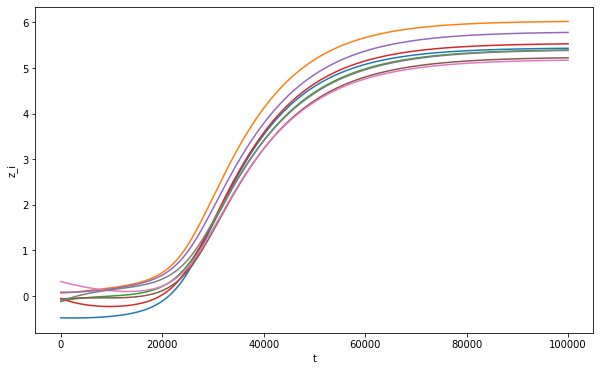

In [55]:
Z_t = reproduce_figure_2a()

plt.figure(figsize=[10,6])
plt.plot(Z_t[:,:,0])
plt.xlabel('t')
plt.ylabel('z_i')

Text(0, 0.5, 'z_i')

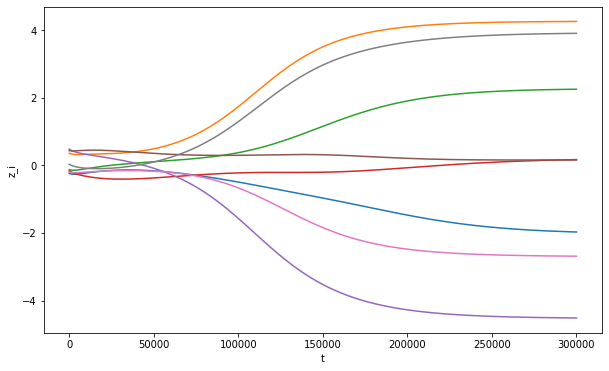

In [56]:
Z_t = reproduce_figure_2b()

plt.figure(figsize=[10,6])
plt.plot(Z_t[:,:,0])
plt.xlabel('t')
plt.ylabel('z_i')